# Отчет о проделанной работе

Выводы.

1. Достигнута точность 68.66%, что меньше требуемой 70%.
2. Для формирования значимых признаков используется в основном subreddit и сверточная сеть для comment.
3. Не используются незначимые признаки вроде author, а также текст основного  сообщения.
4. Учет поверхностных признаков повысил точность на 0.66%, хотя сами по себе они дают точность примерно 58%.
5. Переобучение сверточной сети небольшое, в пределах 2%, результат достигается на первых 5 итерациях. Сверточная сеть позволила получить удивительно хорошие результаты, выделенные признаки сарказма не кажутся очевидными.
6. Время эпохи составляет примерно 15 минут, использование GPU не позволит ускорить решение задачи из-за затрат на кодирование и поиск ошибок.

Для улучшения результатов можно попробовать увеличить размерность эмбеддингов, использовать текст сообщения для выделения возможных признаков с новыми фильтрами. 

Описание.

Ячейки 163, 7 - Разведочный поиск показал, что признаки author, downs не коррелированы с целью, а признаки score, ups - почему-то только для отрицательных значений. Однако временные признаки - год, месяц, день недели, время суток немного влияют на уровень сарказма, вероятно определяя состав или настроение аудитории.

90 - psub - заполняет словарь DICT для преобразования категориальных признаков в вещественные. Для этого на учебной выборке проводится группировка по данному признаку и в крупных группах  новый признак заменяется на среднее значение цели по группе, иначе - на ноль.
Печатается 100 самых крупных групп: номер группы, число элементов в нец, имя группы, среднее значение цели. Строится график рассеяния по всем группам.  Видно, что признак subreddit является значимым, т.к. в некоторых группах сарказма занчительно больше чем в других. Есть и такие где его мало.
Замена по этому же словарю DICT делается для тестовой выборки.
Новый признак - subreddit

26 - psr - повторяет функцию psub для score, ups но только для отрицательных значений категориального признака.  Значимость этого признака почему-то велика, но таких объектов нет так много.

96 - формирует новые временные признаки

97 - вычисляет новые временные признаки группировкой и усреднением цели через psr.

93 - REPLACE - функция которая заменяет столбец по словарю DICT если значение меньше 0.

90 - REP2 - функция которая заменяет столбец по словарю DICT если значение есть в словаре, иначе - 0.

110,111 - читает признак, полученный из DL, заменяет его по словарю из index и помещает в столбец 'pt1'.

118, 120 - выделение матриц сформированных признаков b целей для моделей, сохранение.

121 - масштабирование матриц X_train, X_test.

130 - использование логистической регрессии для построения модели на учебной выборке и получения точности прогноза на тестовой. Модель корректна, поскольку никак не использует информацию о тестовой выборке.

2 - Загрузка PyTorch библиотек и токенизатора

46 - Загрузка датасетов, разбитых на учебную и тестовую выборку.

48 - Модель сверточной сети. Используется два полносвязных слоя на 100 и 20 нейронов, без них выделения значимых признаков не происходит.
Используются эмбеддинги glove.6B.100d, проводится их дообучение.

84 - функции обучения и тестирования сети train, evaluate.

86 - запуск сети с выбором лучшего значения и сохранением результата.
Запись результата работы сети в виде прогноза с индексами в файлы train_pt.csv, test_pt.csv.


In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

from IPython.core.debugger import set_trace
#set_trace()

import logging
logging.basicConfig(filename="pt.log", level=logging.INFO)

In [2]:

from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchsummary import summary

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

import en_core_web_sm
from sklearn import metrics


SEED = 42
np.random.seed(SEED)

In [87]:
df = pd.read_csv('sarcasm.csv')
      
#    "print(df.tail())\n",
#    "df.drop('id', 1, inplace=True)\n",
#    "df.drop('jaccard', 1, inplace=True)\n",
#    "#print(df.head())"


In [4]:
df = shuffle(df)
df[1:1000].to_csv('3.csv', index=False)
df[1:10000].to_csv('4.csv', index=False)
df[1:100000].to_csv('5.csv', index=False)

In [5]:
df3 = pd.read_csv('3.csv')
df4 = pd.read_csv('4.csv')
df5 = pd.read_csv('5.csv')
print(df3.groupby('label')['label'].count())
print(df4.groupby('label')['label'].count())
print(df5.groupby('label')['label'].count())
y3 = df3['label'].values
y4 = df4['label'].values
y5 = df5['label'].values
y = df['label'].values
y6 = df['label'].values

label
0    513
1    486
Name: label, dtype: int64
label
0    5015
1    4984
Name: label, dtype: int64
label
0    49880
1    50119
Name: label, dtype: int64


In [6]:
s5 = df5.groupby('subreddit')['subreddit'].count()
s6 = df.groupby('subreddit')['subreddit'].count()

In [13]:
s6.values.shape

(14878,)

In [7]:
s61 = np.sort(s6.values)[::-1]
i61 = np.argsort(s6.values)[::-1]
print(s61[0:10], i61[0:10])

[65677 39496 26377 21037 18988 17939 16891 16154 14161 14150] [  587 12604 14726 11282 12404 10255 12041 12492 14090 12056]


In [8]:
xx = []
yy = []
for i in range(10000):
    n1 = s61[i]
    i1 = i61[i]
    n2 = s6[i1]
    sub = s6.index[i1]
    s1 = df[df.subreddit == sub]['label'].values.mean()
    #print(i, n1, i1, n2, sub, s1)
    xx.append(np.log(n1))
    yy.append(s1)

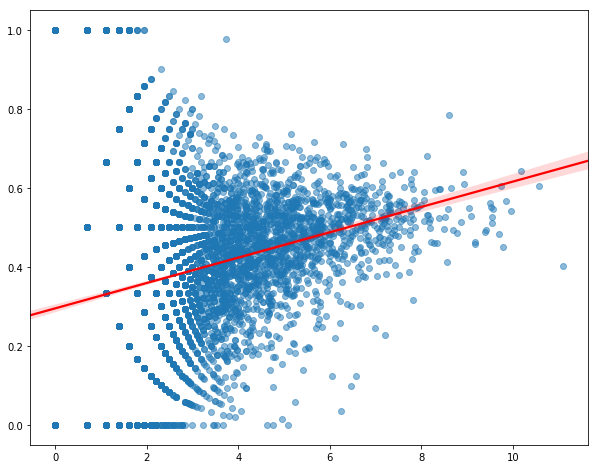

In [149]:
sns.regplot(xx, yy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'});

In [9]:
a6 = df.groupby('author')['author'].count()
a61 = np.sort(a6.values)[::-1]
i61 = np.argsort(a6.values)[::-1]
print(a61[0:10], i61[0:10])

[845 432 422 404 342 318 302 300 252 251] [ 14907 218697  85051 109459 188433 201605 205649  20835  22673 232025]


In [162]:
xx = []
yy = []
for i in range(1000):
    n1 = a61[i]
    i1 = i61[i]
    n2 = a6[i1]
    sub = a6.index[i1]
    s1 = df[df.author == sub]['label'].values.mean()
    #print(i, n1, i1, n2, sub, s1)
    xx.append(np.log(n1))
    yy.append(s1)

In [10]:
a61.shape

(256561,)

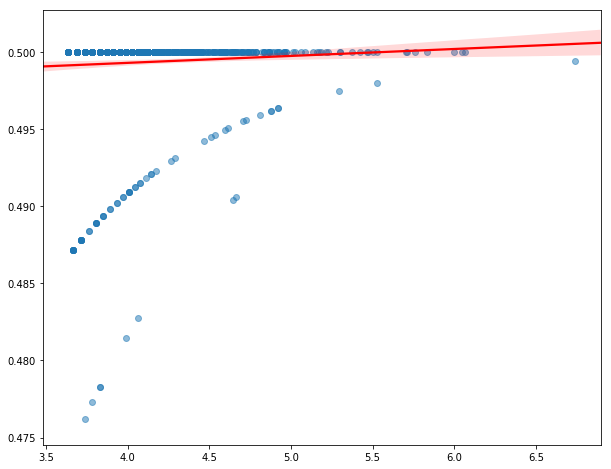

In [163]:
sns.regplot(xx, yy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'});

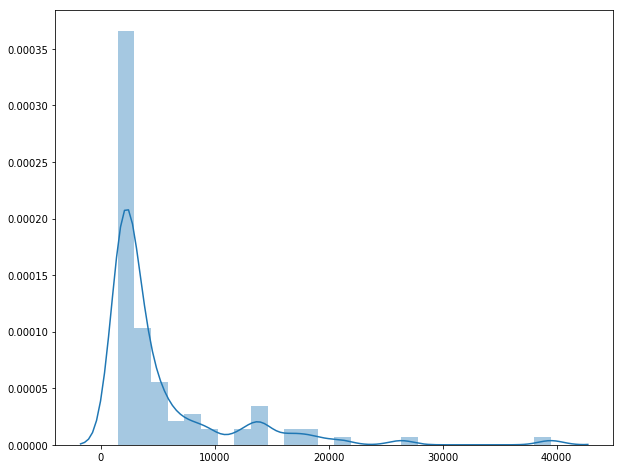

In [94]:
sns.distplot(s63);

In [43]:
df5.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Lol,dayman-mokaffe,nyjets,5,-1,-1,2016-11,2016-11-06 20:56:18,I'll be shocked if he doesnt throw a pick
1,1,Because Blizzard is a charity organization ded...,thatrotteneggsmell,hearthstone,8,8,0,2015-08,2015-08-22 12:32:08,Can anyone explain to me why Blizzard has to g...
2,0,If you can have no influence in the EU how wil...,lebron181,ukpolitics,3,3,0,2016-06,2016-06-22 19:33:50,"And look at the difference it made, all that h..."
3,1,Obviously that means she's a casual,Lolola2,survivor,12,12,0,2016-05,2016-05-06 10:45:36,Didn't even cross her mind about Michele winning.
4,1,Spoiler alert.,V2Blast,anime,1,1,0,2013-09,2013-09-09 08:27:19,"Well, considering that I don't see Eren and Mi..."


In [23]:
df1 = pd.read_csv('1000.csv')


In [12]:
y5 = df5['label'].values

In [13]:
from scipy.stats import chi2_contingency
obs = np.array([[43, 9], [44, 4]])
chi2_contingency(obs)

(1.0724852071005921, 0.300384770390566, 1, array([[45.24,  6.76],
        [41.76,  6.24]]))

In [36]:
DICT

{-1: 0.6526458616010855,
 -2: 0.6471571906354515,
 -3: 0.670605612998523,
 -4: 0.6785714285714286,
 -5: 0.6939759036144578,
 -6: 0.693069306930693,
 -7: 0.6791666666666667,
 -8: 0.735632183908046,
 -10: 0.7,
 -9: 0.656,
 -11: 0.69,
 -13: 0.68,
 -12: 0.6376811594202898,
 -15: 0.6981132075471698,
 -14: 0.7391304347826086,
 -17: 0.7027027027027027,
 -16: 0.6857142857142857,
 -18: 0.6296296296296297,
 -22: 0.7391304347826086,
 -20: 0.8181818181818182,
 -19: 0.5789473684210527,
 -21: 0.4375,
 -23: 0.7333333333333333,
 -24: 0.7857142857142857,
 -30: 0.6923076923076923,
 -32: 0.3,
 -27: 0.7777777777777778,
 -26: 0.3333333333333333,
 -33: 0.7777777777777778,
 -28: 0.5555555555555556,
 -25: 0.75,
 -37: 0.3333333333333333,
 -48: 0.5,
 -50: 0.4,
 -34: 0.6,
 -29: 0.8,
 -31: 1.0,
 -35: 0.6}

In [ ]:
#################################################### Последняя модель 6

In [88]:
# df6 - train6.csv
# df7 - test6.csv

df6 = pd.read_csv('train6.csv')
df7 = pd.read_csv('test6.csv')

In [89]:
y6_train = df6['label'].values
y6_test = df7['label'].values
print(y6_train.shape, y6_test.shape)

(800000,) (210826,)


0 52043 535 52043 AskReddit 0.4000730165440117
1 31323 11429 31323 politics 0.6044440187721483
2 20815 13358 20815 worldnews 0.6407398510689407
3 16714 10226 16714 leagueoflegends 0.5451118822543976
4 15054 11256 15054 pcmasterrace 0.5682210708117443
5 14121 9288 14121 funny 0.4523050775440833
6 13399 10919 13399 news 0.6002686767669229
7 12813 11332 12813 pics 0.4816982751892609
8 11302 12774 11302 todayilearned 0.5505220314988497
9 11283 10933 11283 nfl 0.5102366391917044
10 11147 10864 11147 nba 0.5286624203821656
11 10775 2707 10775 GlobalOffensive 0.5488631090487239
12 10697 234 10697 AdviceAnimals 0.5620267364681687
13 9836 13115 9836 videos 0.4953233021553477
14 9493 9355 9493 gaming 0.49510165385020544
15 7631 6381 7631 The_Donald 0.4611453282662823
16 7561 6893 7561 WTF 0.460388837455363
17 6968 9712 6968 hockey 0.5287026406429391
18 6692 12245 6692 soccer 0.5473699940227137
19 5935 6604 5935 TumblrInAction 0.6101095197978096
20 5865 7527 5865 atheism 0.6414322250639386
21 552

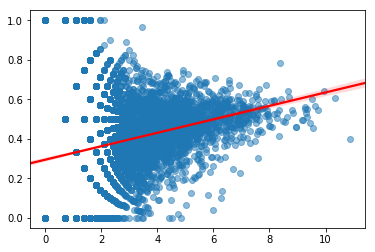

In [90]:
def REP2(x):
    ret = 0
    if x in DICT:
        ret = DICT[x]
    return ret

def psub(D, D2, name, N):
    global DICT
    DICT = dict()
    
    v6 = D.groupby(name)[name].count()
    v61 = np.sort(v6.values)[::-1]
    i61 = np.argsort(v6.values)[::-1]

    xx = []
    yy = []
    for i in range(N):
        n1 = v61[i] # размер группы элемента
        i1 = i61[i] # индекс элемента
        sub = v6.index[i1] # имя элемента
        n2 = v6[sub] # = n1 - серия как словарь
        s1 = D[D[name] == sub]['label'].values.mean()
        if i < 100:
            print(i, n1, i1, n2, sub, s1)
        xx.append(np.log(np.abs(n1)))
        yy.append(s1)
        DICT[sub] = s1

    name1 = name + '1'
    D[name1] = D[name].apply(REP2)
    D2[name1] = D2[name].apply(REP2)
            
    sns.regplot(xx, yy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'});    
   
psub(df6, df7, 'subreddit', 10000)

In [94]:
print(df6.head(1))
df7.head(1)

    index  label                                            comment  \
0  318764      1  Don't you make me come over there and liberate...   

           author  subreddit  score  ups  downs     date          created_utc  \
0  hotelcharlie22  AskReddit      1    1      0  2016-08  2016-08-24 01:13:14   

                                 parent_comment  subreddit1  score1  ups1  
0  Well for me it is "not at all" so Im fine :)    0.400073     0.0   0.0  


,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,subreddit1,score1,ups1
0,614326,1,original content,PatrickMcC,gif,0,0,0,2015-07,2015-07-17 13:28:45,When your bro helps you get a job. [x-post r/J...,0.407407,0.0,0.0


In [106]:
def REPLACE(x):
    ret = 0
    if x < 0  and x in DICT:
        ret = DICT[x]
    return ret

def psr(D, D2, name, N, LESS):
    global DICT
    DICT = dict()
    
    if LESS < 0:
        LESS = -1
    else:
        LESS = 1
    
    v6 = D.groupby(name)[name].count()
    v61 = np.sort(v6.values)[::-1]
    i61 = np.argsort(v6.values)[::-1]

    xx = []
    yy = []
    for i in range(N):
        n1 = v61[i] # размер группы элемента
        i1 = i61[i] # индекс элемента
        sub = v6.index[i1] # имя элемента
        n2 = v6[sub] # = n1 - серия как словарь
        s1 = D[D[name] == sub]['label'].values.mean()
        #if sub >= 0:
        if (LESS < 0 and sub < 0) or LESS > 0:
            print(i, n1, i1, n2, sub, s1)
            xx.append(np.log(np.abs(n1)))
            yy.append(s1)
            DICT[sub] = s1

    name1 = name + '1'
    if LESS < 0:
        D[name1] = D[name].apply(REPLACE)
        D2[name1] = D2[name].apply(REPLACE)
    else:
        D[name1] = D[name].apply(REP2)
        D2[name1] = D2[name].apply(REP2)
            
    #sns.regplot(xx, yy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'});    
   
psr(df6, df7, 'score', 200, -1)
psr(df6, df7, 'ups', 200, -1)

7 18080 125 18080 -1 0.6571349557522124
11 9455 124 9455 -2 0.6750925436277102
16 5322 123 5322 -3 0.6739947388199925
19 4322 122 4322 -4 0.6730680240629339
22 3289 121 3289 -5 0.6719367588932806
26 2457 120 2457 -6 0.6927146927146928
29 1924 119 1924 -7 0.6683991683991684
34 1487 118 1487 -8 0.7027572293207801
37 1187 117 1187 -9 0.6815501263689975
41 933 116 933 -10 0.6645230439442658
46 799 115 799 -11 0.6533166458072591
51 624 114 624 -12 0.6778846153846154
52 578 113 578 -13 0.643598615916955
62 414 112 414 -14 0.7028985507246377
65 388 111 388 -15 0.6623711340206185
69 324 110 324 -16 0.6481481481481481
74 287 109 287 -17 0.6550522648083623
79 244 108 244 -18 0.6024590163934426
84 221 107 221 -19 0.6470588235294118
92 174 106 174 -20 0.7183908045977011
94 165 105 165 -21 0.6363636363636364
96 151 104 151 -22 0.6887417218543046
104 132 103 132 -23 0.7424242424242424
115 107 100 107 -26 0.6728971962616822
118 103 102 103 -24 0.6407766990291263
122 94 101 94 -25 0.6276595744680851
1

In [7]:
# Бинарная точность - для 'downs'
def bin_acc(x1, y1):
    return np.sum(x1 == y1) / y1.shape[0]

x1 = abs(df5['downs']).values
y1 = df5['label'].values
print('bin_acc:', bin_acc(x1, y1))

bin_acc: 0.4803848038480385


In [277]:
# date

In [8]:
df5.date.describe()

count       99999
unique         96
top       2016-12
freq         5314
Name: date, dtype: object

In [30]:
df5['month'] = df5['date'].str[5:7]
print(df5['month'].head())
df5['year'] = df5['date'].str[0:4]
print(df5['year'].head())
#df5['created_utc']

0    02
1    12
2    03
3    09
4    10
Name: month, dtype: object
0    2016
1    2014
2    2012
3    2016
4    2013
Name: year, dtype: object


In [33]:
import datetime
import time 

t = time.strptime('2016-11-06 20:56:18', '%Y-%m-%d %H:%M:%S')
print(t.tm_wday, t.tm_hour)

6 20


In [9]:
df5['t1'] = pd.to_datetime(df5['created_utc'])
df5['dw'] = df5['t1'].dt.dayofweek
df5['dh'] = df5['t1'].dt.hour
df5['dy'] = df5['t1'].dt.year
df5['dm'] = df5['t1'].dt.month

In [38]:
psr(df5, 'dm', 12)
psr(df5, 'dy', 8)
psr(df5, 'dw', 7)
psr(df5, 'dh', 24)

In [96]:
df6['t1'] = pd.to_datetime(df6['created_utc'])
df6['dw'] = df6['t1'].dt.dayofweek
df6['dh'] = df6['t1'].dt.hour
df6['dy'] = df6['t1'].dt.year
df6['dm'] = df6['t1'].dt.month

df7['t1'] = pd.to_datetime(df7['created_utc'])
df7['dw'] = df7['t1'].dt.dayofweek
df7['dh'] = df7['t1'].dt.hour
df7['dy'] = df7['t1'].dt.year
df7['dm'] = df7['t1'].dt.month

In [107]:
psr(df6, df7, 'dm', 12, 1)
psr(df6, df7, 'dy', 8, 1)
psr(df6, df7, 'dw', 7, 1)
psr(df6, df7, 'dh', 24, 1)

0 88295 11 88295 12 0.46556430148932554
1 80672 10 80672 11 0.48276973423244746
2 78813 9 78813 10 0.4886376612995318
3 73260 7 73260 8 0.5068796068796069
4 71332 8 71332 9 0.49855604777659396
5 70646 6 70646 7 0.5085638252696544
6 63498 5 63498 6 0.5129295410879082
7 61344 4 61344 5 0.5112480438184663
8 57092 3 57092 4 0.5103867442023401
9 55251 2 55251 3 0.5102894065265787
10 50967 0 50967 1 0.5184334961838052
11 48830 1 48830 2 0.5176326029080484
0 376638 7 376638 2016 0.46839139969944615
1 227010 6 227010 2015 0.5212677855601074
2 108780 5 108780 2014 0.5340871483728626
3 50216 4 50216 2013 0.5383343954118209
4 21639 3 21639 2012 0.5341744073201165
5 10090 2 10090 2011 0.5462834489593658
6 4169 1 4169 2010 0.5665627248740706
7 1458 0 1458 2009 0.5775034293552812
0 123593 2 123593 2 0.5041628571197397
1 123032 3 123032 3 0.50332433838351
2 121549 1 121549 1 0.5055985651877021
3 118548 4 118548 4 0.4989455747882714
4 115833 0 115833 0 0.5020244662574569
5 100503 6 100503 6 0.49503994

In [111]:
df6.head(1)

,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,...,t1,dw,dh,dy,dm,dm1,dy1,dw1,dh1,pt1
0,318764,1,Don't you make me come over there and liberate...,hotelcharlie22,AskReddit,1,1,0,2016-08,2016-08-24 01:13:14,...,2016-08-24 01:13:14,2,1,2016,8,0.50688,0.468391,0.504163,0.484974,0.695633


In [113]:
df7.head(1)

,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,...,t1,dw,dh,dy,dm,dm1,dy1,dw1,dh1,pt1
0,614326,1,original content,PatrickMcC,gif,0,0,0,2015-07,2015-07-17 13:28:45,...,2015-07-17 13:28:45,4,13,2015,7,0.508564,0.521268,0.498946,0.513081,0.357585


In [100]:
train_pt = pd.read_csv('train_pt.csv')
test_pt = pd.read_csv('test_pt.csv')
train_pt.head()

,index,y_pred,y_test
0,172456,0.646753,1.0
1,678167,0.365489,0.0
2,932829,0.222082,0.0
3,601383,0.547160,0.0
4,631650,0.569939,0.0


In [110]:
DICT = train_pt.set_index('index')['y_pred'].to_dict()
df6['pt1'] = df6['index'].apply(REP2)

In [112]:
DICT = test_pt.set_index('index')['y_pred'].to_dict()
df7['pt1'] = df7['index'].apply(REP2)

In [114]:
# 6,7


In [118]:
dX_train = df6[['subreddit1', 'pt1', 'dy1', 'dm1', 'dw1', 'dh1', 'score1', 'ups1']]
dX_test = df7[['subreddit1', 'pt1', 'dy1', 'dm1', 'dw1', 'dh1', 'score1', 'ups1']]
dX_train.to_csv('X_train.csv', index=False)
dX_test.to_csv('X_test.csv', index=False)
dy_train = df6['label']
dy_test = df7['label']
dy_train.to_csv('y_train.csv', index=False)
dy_test.to_csv('y_test.csv', index=False)

In [129]:
X_train = dX_train.values
X_test = dX_test.values
y_train = dy_train.values
y_test = dy_test.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800000, 8) (210826, 8) (800000,) (210826,)


In [121]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
clf = LogisticRegression(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('acc=', acc)

y_pred_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print('acc_train=', acc_train)

acc= 0.6864997675808486
acc_train= 0.71363875


In [126]:
clf = LinearSVC(C=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('acc=', acc)

y_pred_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print('acc_train=', acc_train)

acc= 0.686580402796619
acc_train= 0.7133125


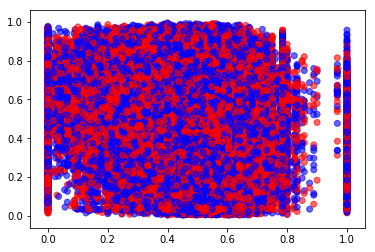

In [131]:
N = 1000
y1 = y_train[:N]
col = pd.Series(y1).astype(str)
col[y1 == 1] = 'red'
col[y1 == 0] = 'blue'
plt.scatter(X_train[:, 0], X_train[:, 1], color=col.values, alpha=0.6);

In [39]:
# 5
X = df5[['dy1', 'dm1', 'dw1', 'dh1', 'score1', 'ups1', 'subreddit1']].values
y = df5['label'].values
print(X.shape, y.shape)

(99999, 7) (99999,)


In [95]:
#2

X = df5[['dm1', 'dw1', 'dh1', 'subreddit1']].values
y = df5['label'].values
print(X.shape, y.shape)


(99999, 4) (99999,)


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE


In [42]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(74999, 7) (25000, 7) (74999,) (25000,)


In [97]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('acc=', acc)

y0 = clf.predict(X_train)
acc0 = accuracy_score(y_train, y0)
print('acc0=', acc0)
print(clf.feature_importances_)

acc= 0.53368
acc0= 0.8992653235376472
[0.1628399  0.13826952 0.24502401 0.45386656]


In [43]:
clf = LogisticRegression(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('acc=', acc)

y0 = clf.predict(X_train)
acc0 = accuracy_score(y_train, y0)
print('acc0=', acc0)

acc= 0.57976
acc0= 0.5825144335257804


In [66]:
clf = LinearSVC(C=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('acc=', acc)

y0 = clf.predict(X_train)
acc0 = accuracy_score(y_train, y0)
print('acc0=', acc0)

acc= 0.5778
acc0= 0.5817277563700849


(99999, 7)
(30000, 7)


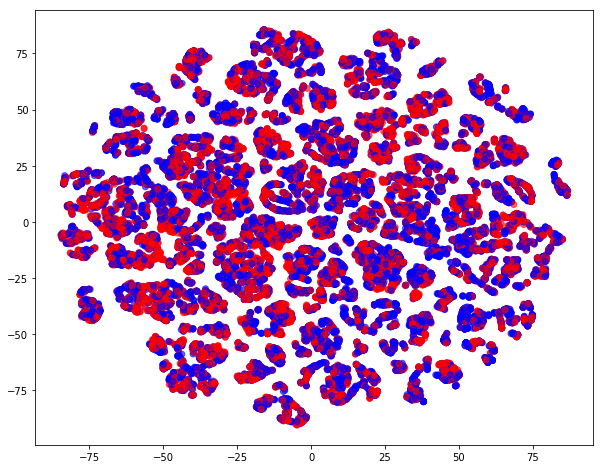

In [173]:
N = 30000
X1 = X[:N, :]
print(X.shape)
print(X1.shape)

y1 = y[:N]
col = pd.Series(y1).astype(str)
col[y1 == 1] = 'red'
col[y1 == 0] = 'blue'

X_embedded = TSNE(perplexity=30).fit_transform(X1)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=col.values, alpha=0.6);

In [ ]:
#####################################################

In [14]:
#dft = df5[['label', 'comment', 'parent_comment']]
dft = df5[['label', 'comment']]
dft.head()

,label,comment
0,1,"wait, you have to win the candidates to challe..."
1,1,I mean how could anyone not see that it is ant...
2,0,"Funny thing, most of the girl pants I've bough..."
3,0,"Also Ranch dressing, because LBJ was Texan, an..."
4,0,Being adorable.


In [15]:
dft.to_csv('t5.csv', index=False)

In [16]:
df.shape
#df6 = df[['label', 'comment', 'parent_comment']]
df6 = df[['label', 'comment']]
df6.head()

,label,comment
608627,1,And he sure as hell is successful!
456977,1,"wait, you have to win the candidates to challe..."
803801,1,I mean how could anyone not see that it is ant...
926708,0,"Funny thing, most of the girl pants I've bough..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an..."


In [17]:
df6.to_csv('t6.csv', index=False)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

import spacy
import nltk
import gensim

import en_core_web_sm

spacy_en = en_core_web_sm.load()

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            


In [23]:
# tt

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=torch.int64)


FILE = 't6.csv'
print(FILE)

dataset = TabularDataset(FILE, format='csv', 
    fields=[('label', LABEL), ('text', TEXT)], skip_header=True)

TEXT.build_vocab(dataset, min_freq=5, vectors="glove.6B.100d")

LABEL.build_vocab(dataset)

train_data, test_data = dataset.split(stratified=True, split_ratio=0.8)
                            
#train, valid = train.split(stratified=True)

batch_size = 32

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_sizes=(batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

#train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#    (train, valid, test),
#    batch_sizes=(batch_size, batch_size, batch_size),
#    shuffle=True,
#    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
#)


pretrained_embeddings = TEXT.vocab.vectors
#model.embedding.weight.data.copy_(pretrained_embeddings)

print(len(TEXT.vocab.itos))
print(TEXT.vocab.itos[:20])

t6.csv
40158
['<unk>', '<pad>', '<eos>', 'like', 'would', 'yeah', 'people', 'get', 'one', 'well', 'know', 'think', 'good', 'right', 'really', 'sure', 'time', 'ca', 'could', 'yes']


In [74]:
TEXT.build_vocab(dataset, min_freq=50, vectors="glove.6B.100d")
print(len(TEXT.vocab.itos))
print(TEXT.vocab.itos[:20])

batch_size = 64

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_sizes=(batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

pretrained_embeddings = TEXT.vocab.vectors
#model.embedding.weight.data.copy_(pretrained_embeddings)


10123
['<unk>', '<pad>', '<eos>', 'like', 'would', 'yeah', 'people', 'get', 'one', 'well', 'know', 'think', 'good', 'right', 'really', 'sure', 'time', 'ca', 'could', 'yes']


In [ ]:
# t5
#11053
#['<unk>', '<pad>', '<eos>', 'like', 'would', 'yeah', 'people', 'get', 'one', 'well', 'know', 'think', 'money', 'good', 'right', 'really', 'sure', 'ca', 'time', 'make']

In [87]:
len(train_data)

808660

In [88]:
FILE = 'test.csv'
print(FILE)

test6 = TabularDataset(FILE, format='csv', 
    fields=[(None, None), ('label', LABEL), ('text', TEXT)], skip_header=True)

test.csv


In [93]:
print(len(test6), batch_size)

210826 64


In [94]:
batch_size = 64

test6_iterator = BucketIterator(test6, batch_size, shuffle=True,
    sort_key=lambda x: len(x.text))

In [46]:
# 5


TRAIN = 'train5.csv'
TEST = 'test5.csv'
FREQ = 5

TRAIN = 'train6.csv'
TEST = 'test6.csv'
FREQ = 50

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=torch.int64)

INDEX = Field(sequential=False, use_vocab=False, dtype=torch.int64)

d_train = TabularDataset(TRAIN, format='csv', 
    fields=[('index', INDEX), ('label', LABEL), ('text', TEXT)], skip_header=True)

d_test = TabularDataset(TEST, format='csv', 
    fields=[('index', INDEX), ('label', LABEL), ('text', TEXT)], skip_header=True)

batch_size = 32

TEXT.build_vocab(d_train, min_freq=FREQ, vectors="glove.6B.100d")
LABEL.build_vocab(d_train)

train_iterator = BucketIterator(d_train, batch_size, shuffle=True,
    sort_key=lambda x: len(x.text))

test_iterator = BucketIterator(d_test, batch_size, shuffle=True,
    sort_key=lambda x: len(x.text))

pretrained_embeddings = TEXT.vocab.vectors

print(len(TEXT.vocab.itos))
print(TEXT.vocab.itos[:20])
print(len(d_train), len(d_test), batch_size)


8738
['<unk>', '<pad>', '<eos>', 'like', 'would', 'yeah', 'people', 'get', 'one', 'well', 'know', 'think', 'good', 'right', 'sure', 'really', 'time', 'ca', 'yes', 'could']
800000 210826 32


In [101]:
import sys
sys.getsizeof(train5)

56

In [48]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, 
        #        kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        
        # nn.Conv1d(embed_size, hidden_size, k, padding=5)
        
        self.conv_0 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                                kernel_size=(filter_sizes[0], embedding_dim))

        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=n_filters,
                        kernel_size=(filter_sizes[1], embedding_dim))        

        self.conv_2 = nn.Conv1d(in_channels=1, out_channels=n_filters,
                        kernel_size=(filter_sizes[2], embedding_dim))        
        
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[3], embedding_dim))        

        self.fc1 = nn.Linear(len(filter_sizes)*n_filters, 100)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(100, 20)
        
        self.fc3 = nn.Linear(20, 1)
        
    def forward(self, x):
        
        #x = [batch size, sent len]
        #print('1 - x size=', x.size())

        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        #print('2 - embedded size=', embedded.size())
        
        embedded = embedded.unsqueeze(1)
        
        #print('2 - embedded size=', embedded.size())
        
        #embedded = [batch size, 1, sent len, emb dim]
        #print('= embedded size=', embedded.size())
        
        #conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        conved_3 = F.relu(self.conv_3(embedded).squeeze(3))        
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        #pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #print('40 - conved size0=', conved_0.size())
        #print('41 - conved size1=', conved_1.size())
        #print('42 - conved size2=', conved_2.size())
        #print('43 - conved size3=', conved_3.size())

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)        
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)                

        #pooled_n = [batch size, n_filters]        
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        x = self.fc1(cat)
        x = self.fc2(x)
        x = self.fc3(x)
            
        return x
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4,5]

#OUTPUT_DIM = len(LABEL.vocab)
OUTPUT_DIM = 1

DROPOUT = 0.5
print(INPUT_DIM, OUTPUT_DIM)

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, 
                                FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# +GLOVE
model.embedding.weight.data.copy_(pretrained_embeddings)

# +FROZEN
model.embedding.weight.requires_grad=False

print(model.embedding.weight, model.embedding.weight.size())

print(model)    



8738 1
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.9554, -0.2911, -0.0746,  ..., -1.1536,  0.7494, -0.4389],
        [-0.1964, -0.6269, -0.6126,  ..., -1.0134, -0.6657, -0.6404],
        [-0.0060,  0.4116,  0.2611,  ..., -0.4815,  0.4309,  0.4570]]) torch.Size([8738, 100])
CNN(
  (embedding): Embedding(8738, 100)
  (conv_0): Conv1d(1, 100, kernel_size=(2, 100), stride=(1,))
  (conv_1): Conv1d(1, 100, kernel_size=(3, 100), stride=(1,))
  (conv_2): Conv1d(1, 100, kernel_size=(4, 100), stride=(1,))
  (conv_3): Conv1d(1, 100, kernel_size=(5, 100), stride=(1,))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


In [39]:
optimizer = optim.Adam(model.parameters())

len1 = len(train_iterator)    
print(len1)

epoch_loss = 0
epoch_acc = 0
    
model.train()
    
for batch in train_iterator:
    
    optimizer.zero_grad()
    
    #text = bb5(batch.text[0])
    #print(text.size())
    text = batch.text[0]
    target = batch.label        
    
    #print(target.size(), target)
    #print(text.size(), text)
    
    #print(target.size(), text.size())
    
    predictions = model(text)
    
    #break
    
    prob = F.sigmoid(predictions)
    loss = F.binary_cross_entropy(prob, target.float())
    acc = accuracy(prob, target)
        
    loss.backward()
    optimizer.step()
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()

print(epoch_loss / len1, epoch_acc / len1)

3125
0.6548130699062348 0.504025


In [166]:
aa = torch.tensor(range(5))
aa = aa.unsqueeze(1)
print(aa)

tensor([[0],
        [1],
        [2],
        [3],
        [4]])


In [160]:
#print(model.parameters)
#for param in model.parameters():
#      print(type(param.data), param.size())

In [186]:
a = torch.randn(32, 1, 15, 100)  
#m = nn.Conv1d(1, 100, (2,100), padding=1) 
m = nn.Conv1d(1, 100, (2,100)) 
out = m(a)
print(out.size())
print(m)
print(m.weight.size())
print(m.bias.size())

pool = F.max_pool1d(out, out.shape[2]).

torch.Size([32, 100, 14, 1])
Conv1d(1, 100, kernel_size=(2, 100), stride=(1,))
torch.Size([100, 1, 2, 100])
torch.Size([100])


In [187]:
out.shape[2]

14

In [116]:
aa = list(model.conv_0.parameters())
print(aa[0].size())
aa[0][1,0,1,1]

torch.Size([100, 1, 2, 100])


tensor(0.0405, grad_fn=<SelectBackward>)

In [12]:
nall = 0
for name, t in model.named_children():
    numel = nattr(t)
    #print('-', t)
    if hasattr(t, 'weight'):
        d = getattr(t, 'weight')
        print('   + weight=', d.size())
        
    if hasattr(t, 'bias'):
        d = getattr(t, 'bias')
        print('   + bias=', d.size())
        
    print('-', name, '-', t, '-', numel, '\n')
    
    #print('    ', dir(t))
    nall += numel
print('nall=', nall)

          weight 1104200
   + weight= torch.Size([11042, 100])
- embedding - Embedding(11042, 100) - 1104200 

          bias 100
          weight 20000
   + weight= torch.Size([100, 1, 2, 100])
   + bias= torch.Size([100])
- conv_0 - Conv1d(1, 100, kernel_size=(2, 100), stride=(1,)) - 20100 

          bias 100
          weight 30000
   + weight= torch.Size([100, 1, 3, 100])
   + bias= torch.Size([100])
- conv_1 - Conv1d(1, 100, kernel_size=(3, 100), stride=(1,)) - 30100 

          bias 100
          weight 40000
   + weight= torch.Size([100, 1, 4, 100])
   + bias= torch.Size([100])
- conv_2 - Conv1d(1, 100, kernel_size=(4, 100), stride=(1,)) - 40100 

          bias 100
          weight 50000
   + weight= torch.Size([100, 1, 5, 100])
   + bias= torch.Size([100])
- conv_3 - Conv1d(1, 100, kernel_size=(5, 100), stride=(1,)) - 50100 

          bias 100
          weight 40000
   + weight= torch.Size([100, 400])
   + bias= torch.Size([100])
- fc1 - Linear(in_features=400, out_features=1

In [13]:
# FROZEN
model.embedding.weight.requires_grad=False
print(model.embedding.weight, model.embedding.weight.size())

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4198, -0.1956, -0.2468,  ..., -0.4826, -0.6925, -0.5460],
        [-0.0452, -0.1997, -0.0924,  ..., -0.1684, -0.1677,  0.9691],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([11042, 100])


In [52]:
model.embedding.weight.requires_grad=True
model.embedding.weight.requires_grad

True

In [ ]:
def pattr(obj, lev):
    #print(dir(obj))
    for s in dir(obj):
        if not hasattr(obj, s):
            continue
        if s.startswith('_'):
            continue
        #set_trace()
        at = getattr(obj, s)
        
        ts = type(at)
        tab = '        ' * lev
        print(tab, s, ts)
        if str(ts) == "<class 'method'>":
            continue
        print(tab, '=====================')
        if str(ts).count('parameter'):
            print(tab, '==', at.size(), str(at))
        else :
            print(tab, '==', str(at))
            
        if lev < 1:
            pattr(at, lev + 1)
        
pattr(model, 0)   


In [9]:
# Число нейронов, без рекурсии
def nattr(obj):
    numel = 0
    #print(dir(obj))
    for s in dir(obj):
        if s.startswith('_'):
            continue
        at = getattr(obj, s)
        ts = type(at)
        if str(ts).count('parameter'):
            #print(str(s), at.size(), at.numel(), str(at))
            tab = '         '
            print(tab, str(s), at.numel())
            numel += at.numel()
    return numel
        
nattr(model.conv_3)   


          bias 100
          weight 50000


50100

In [84]:
# model

def accuracy(y_pred, y_true):
    y_true = y_true.byte()
    y_pred = torch.ge(y_pred, 0.5)
    return torch.mean(torch.eq(y_pred, y_true).float())


a = torch.rand(5) 
d = torch.ones(5)
print(a, accuracy(a, d))

def bb5(t0):
    s = t0.size()[1]
    if s == 4:
        t0 = F.pad(t0, (0, 1), 'constant', 1)
    elif s == 3:
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
    elif s == 2:        
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)        
    elif s == 1:        
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)
        t0 = F.pad(t0, (0, 1), 'constant', 1)        
        t0 = F.pad(t0, (0, 1), 'constant', 1)                
    return t0

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    i = 0
    for batch in iterator:
        optimizer.zero_grad()
        
        text = bb5(batch.text[0])
        #text = batch.text[0]
        #print(text.size())
        #target = batch.label    
        
        y_train = batch.label.float()  
        
        i += 1
        #if i > 2: 
        #    break
        
        logging.info(str(epoch) + ' ' + str(i) + ' ' + str(text.size()))
       
        pred = model(text)        
        y_pred = F.sigmoid(pred)        
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y_train)
        acc = accuracy(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    out = 'index,y_pred,y_test\n'
    PRINT = 0
    
    model.eval()
    
    with torch.no_grad():
        
        i = 0
        for batch in iterator:
            
            i += 1
            text = bb5(batch.text[0])
            #text = batch.text[0]
            target = batch.label        
            
            y_test = batch.label.float()  
            
            ind = batch.index
            
            predictions = model(text)
            prob = F.sigmoid(predictions)
            
            pred = model(text)        
            y_pred = F.sigmoid(pred)            
            y_pred = y_pred.squeeze()
            loss = criterion(y_pred, y_test)
            acc = accuracy(y_pred, y_test)
            
            if i == -1:
                print('text', text)
                print('target', target)
                print('ind', ind)
                print('prob', prob)                
            
            if PRINT:
                list1 = [str(x) for x in ind.tolist()]
                list2 = [str(x) for x in y_pred.tolist()]
                list3 = [str(x) for x in y_test.tolist()]
                for k in range(len(batch)):
                    out += list1[k] + ',' + list2[k] + ',' + list3[k] + '\n'
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #if i > 2:
            #    break
    
    if PRINT:
        with open('test_pt.csv', 'w') as f:
            f.write(out)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

tensor([0.2045, 0.1463, 0.9748, 0.6753, 0.9348]) tensor(0.6000)


In [86]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
N_EPOCHS = 40
BEST = 0
EPOCH = 0

print('len_train=', len(train_iterator))
print('len_test=', len(test_iterator))

for epoch in range(N_EPOCHS):

    start = time.time()        

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #valid_loss, valid_acc = evaluate(model, valid_iterator)
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    elapsed = time.time() - start
    print(f'elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')  
    
    if test_acc > BEST:
        BEST = test_acc
        EPOCH = epoch + 1
        torch.save(model, "t6.pt")

print('best_acc=', BEST, 'epoch_best=', EPOCH)        

len_train= 25000
len_test= 6589
Epoch: 01 | Train Loss: 0.581 | Train Acc: 69.02%
elapsed=772.6 | Test Loss: 0.593 | Test Acc: 67.82%
Epoch: 02 | Train Loss: 0.579 | Train Acc: 69.19%
elapsed=761.5 | Test Loss: 0.592 | Test Acc: 67.93%
Epoch: 03 | Train Loss: 0.578 | Train Acc: 69.30%
elapsed=761.5 | Test Loss: 0.592 | Test Acc: 68.00%
Epoch: 04 | Train Loss: 0.576 | Train Acc: 69.47%
elapsed=766.9 | Test Loss: 0.593 | Test Acc: 67.90%
Epoch: 05 | Train Loss: 0.575 | Train Acc: 69.46%
elapsed=762.7 | Test Loss: 0.591 | Test Acc: 68.07%
Epoch: 06 | Train Loss: 0.573 | Train Acc: 69.63%
elapsed=767.8 | Test Loss: 0.592 | Test Acc: 67.96%
Epoch: 07 | Train Loss: 0.572 | Train Acc: 69.77%
elapsed=766.2 | Test Loss: 0.593 | Test Acc: 68.09%
Epoch: 08 | Train Loss: 0.571 | Train Acc: 69.86%
elapsed=767.9 | Test Loss: 0.593 | Test Acc: 68.08%
Epoch: 09 | Train Loss: 0.570 | Train Acc: 69.89%
elapsed=764.5 | Test Loss: 0.593 | Test Acc: 68.03%
Epoch: 10 | Train Loss: 0.569 | Train Acc: 69.99%


In [ ]:
#############################################

In [76]:
# t6
#model = torch.load("t6.pt")
start = time.time()  
test_loss, test_acc = evaluate(model, test_iterator, criterion)
elapsed = time.time() - start
print(f'| elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  

| elapsed=584.3 | Test Loss: 0.571 | Test Acc: 69.98% |


In [ ]:
model = torch.load("t5.pt")
start = time.time()  
test_loss, test_acc = evaluate(model, test5_iterator)
elapsed = time.time() - start
print(f'| elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  

In [84]:
model = torch.load("t6.pt")
start = time.time()  
test_loss, test_acc = evaluate(model, test_iterator)
elapsed = time.time() - start
print(f'| elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  

| elapsed=40.4 | Test Loss: 0.585 | Test Acc: 68.57% |


In [81]:
# ?
model = torch.load("t6.pt")
start = time.time()  
test_loss, test_acc = evaluate(model, train_iterator)
elapsed = time.time() - start
print(f'| elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  

| elapsed=352.1 | Test Loss: 0.552 | Test Acc: 50.34% |


In [54]:
# t6
model = torch.load("t6.pt")
start = time.time()  
test_loss, test_acc = evaluate(model, test_iterator, criterion)
elapsed = time.time() - start
print(f'| elapsed={elapsed:.1f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')  

| elapsed=148.2 | Test Loss: 0.603 | Test Acc: 67.05% |


In [83]:
# Проверка точности test_pc.csv

d1 = pd.read_csv('test_pt.csv')
y1_prob = d1['y_pred']
y1_pred = y1_prob > 0.5
y1_test = d1['y_test']
print(accuracy_score(y1_test, y1_pred))

d2 = pd.read_csv('train_pt.csv')
y2_prob = d2['y_pred']
y2_pred = y2_prob > 0.5
y2_test = d2['y_test']
print(accuracy_score(y2_test, y2_pred))


0.6772883799910827
0.69976375


In [4]:
import pdb
from IPython.core.debugger import set_trace

In [ ]:
 optimizer.zero_grad()

In [5]:
for i in range(10):
    set_trace()
    print(i)

> <ipython-input-5-7a74ba877499>(3)<module>()
      1 for i in range(10):
      2     set_trace()
----> 3     print(i)



ipdb>  c


0
> <ipython-input-5-7a74ba877499>(2)<module>()
      1 for i in range(10):
----> 2     set_trace()
      3     print(i)



ipdb>  c


1
> <ipython-input-5-7a74ba877499>(3)<module>()
      1 for i in range(10):
      2     set_trace()
----> 3     print(i)



ipdb>  l


      1 for i in range(10):
      2     set_trace()
----> 3     print(i)



ipdb>  h



Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb



ipdb>  l 10


ipdb>  


ipdb>  l 10,11


ipdb>  l 1, 10


      1 for i in range(10):
      2     set_trace()
----> 3     print(i)



ipdb>  pp 1


1


ipdb>  x


*** NameError: name 'x' is not defined


ipdb>  q


BdbQuit: 

In [ ]:
# Torch 

In [ ]:
a = torch.ones(1)
w1 = torch.ones(1, requires_grad=True)
w2 = torch.ones(1, requires_grad=True)
w3 = torch.ones(1, requires_grad=True)
w4 = torch.ones(1, requires_grad=True)

def dd(w1,w2,w3,w4):
    b = w1 * a
    c = w2 * a
    d = (w3 * b) + (w4 * c)
    L = d * d
    return L

#L = dd()
#L.backward()

#print(L, w3, w1.grad.data)

parameters = iter([w1, w2, w3, w4])
optimizer = optim.SGD(parameters, lr = 0.01, momentum=0.9)

lr = torch.tensor(0.01)

for i in range(50):
    
    optimizer.zero_grad()
    L = dd(w1,w2,w3,w4)
    L.backward()
    optimizer.step()
    
    print(i, L, w1)
    
    #r1 = w1
    #r2 = w2
    #r3 = w3
    #r4 = w4
    #r1 = r1 - lr * w1.grad
    #r2 = r2 - lr * w2.grad
    #r3 = r3 - lr * w3.grad
    #r4 = r4 - lr * w4.grad
    
    #w1.data = r1.data
    #w2.data = r2.data
    #w4.data = r3.data
    #w4.data = r4.data
    
    #L = dd(w1,w2,w3,w4)
    
    
    



In [360]:
print(r1.grad, r1.requires_grad)

None True


In [369]:
parameters = iter([w1, w2, w3, w4])
for w in parameters:
    print(w)

tensor([-8.0846], requires_grad=True)
tensor([-2.8123], requires_grad=True)
tensor([1.], requires_grad=True)
tensor([-2.8123], requires_grad=True)


In [129]:
for i in range(10):
    label = df5.ix[i, 'label']
    if label == 1:
        comment = df5.ix[i, 'comment']
        parent = df5.ix[i, 'parent_comment']
        print(i, comment + '\n' + parent + '\n\n')
    

0 Or Maybe Scott as the narrator?
I had an Idea That if There are Tutorials in FNAF World, Phone Guy Should Narrate Them I think it would be pretty cool and a nice touch to the game if for how to use the battle system or if there is any extra side things to do (like crafting potions or something) that phone guy could call and explain to you how to do it. There could also be a little phone or something and it rings when phone guy has a tutorial for you. For example the beginning the game you get into it and then you hear a phone ringing and then the classic hello, hello! and the message goes into something like: I wanted to relay a message for you, to help you with playing the game. Uh, you'll do fine. First there is a message from the developer I'm supposed to read... Uh, Welcome to FNAF World, a magical game for kids and grownups alike, where fantasy and fun come to life. Then of course he would go into the actual mechanics of the game and how to play and he ends up calling you back a

In [52]:
df5.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,...,dh,dy,dm,dy1,dm1,dw1,dh1,score1,ups1,subreddit1
0,1,Or Maybe Scott as the narrator?,INHHHAAALLLE,fivenightsatfreddys,1,1,0,2015-09,2015-09-22 13:10:11,I had an Idea That if There are Tutorials in F...,...,13,2015,9,0.519412,0.501814,0.504421,0.515947,0.0,0.000000,0.524390
1,1,Thanks for your contribution,comical_imbalance,perth,4,-1,-1,2016-11,2016-11-16 07:02:40,No,...,7,2016,11,0.467539,0.483211,0.502016,0.491546,0.0,0.457775,0.529412
2,1,"Yes, because women are fragile and delicate bu...",RotatorX,facepalm,4,4,0,2013-07,2013-07-27 16:13:39,So if a woman is killing someone or hurting a ...,...,16,2013,7,0.528960,0.506583,0.482693,0.511947,0.0,0.000000,0.718182
3,0,"What's even more fucked is that ""hate speech"" ...",RyanGBaker,The_Donald,1,-1,-1,2016-10,2016-10-08 08:09:01,Canadian Imam Accuses Ezra Levant of Hate Spee...,...,8,2016,10,0.467539,0.484194,0.482693,0.492923,0.0,0.457775,0.463646
4,0,Yeah,le_benis,Gamingcirclejerk,1,1,0,2016-08,2016-08-29 19:11:52,"Oh, so they deserve all those millions right?",...,19,2016,8,0.467539,0.502884,0.499246,0.512297,0.0,0.000000,0.083333


0 47226 7 47226 2016 0.46753906746283824
1 28153 6 28153 2015 0.5194117856001137
2 13614 5 13614 2014 0.5307036873806376
3 6250 4 6250 2013 0.52896
4 2739 3 2739 2012 0.5271997079225995
5 1256 2 1256 2011 0.5414012738853503
6 568 1 568 2010 0.5651408450704225
7 193 0 193 2009 0.5595854922279793


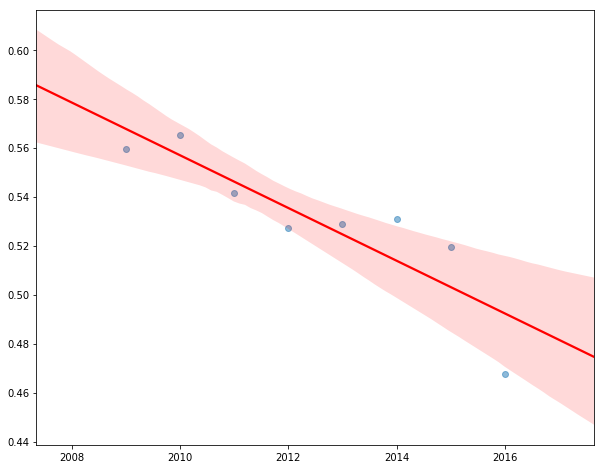

In [24]:
def psd(D, name):

    global DICT
    DICT = dict()
    
    D['dt'] = pd.to_datetime(D['created_utc'])
    D['dw'] = D['dt'].dt.dayofweek
    D['dh'] = D['dt'].dt.hour
    D['dy'] = D['dt'].dt.year
    D['dm'] = D['dt'].dt.month
    
    v6 = D.groupby(name)[name].count()
    v61 = np.sort(v6.values)[::-1]
    i61 = np.argsort(v6.values)[::-1]

    xx = []
    yy = []
    for i in range(v6.shape[0]):
        n1 = v61[i] # размер группы элемента
        i1 = i61[i] # индекс элемента
        sub = v6.index[i1] # имя элемента
        n2 = v6[sub] # = n1 - серия как словарь
        s1 = D[D[name] == sub]['label'].values.mean()
        print(i, n1, i1, n2, sub, s1)
        #xx.append(n1)
        xx.append(sub)
        yy.append(s1)
        DICT[sub] = s1
    
    name1 = name + '1'
    D[name1] = D[name].replace(DICT)
        
    sns.regplot(xx, yy, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'});            
    
psd(df5, 'dy')

0 5823 18 5823 18 0.49613601236476046
1 5776 17 5776 17 0.5036357340720221
2 5774 19 5774 19 0.5122965015587114
3 5759 20 5759 20 0.49887133182844245
4 5608 16 5608 16 0.5119472182596291
5 5536 21 5536 21 0.4902456647398844
6 5197 15 5197 15 0.5331922262843949
7 5152 22 5152 22 0.49417701863354035
8 4938 23 4938 23 0.49210206561360875
9 4820 0 4820 0 0.4811203319502075
10 4692 1 4692 1 0.48444160272804776
11 4551 2 4551 2 0.4798945286750165
12 4543 14 4543 14 0.5159586176535329
13 4398 3 4398 3 0.48794906775807184
14 3991 4 3991 4 0.4645452267602105
15 3731 13 3731 13 0.5159474671669794
16 3437 5 3437 5 0.48327029386092524
17 2822 6 2822 6 0.48547129695251595
18 2811 12 2811 12 0.504091070793312
19 2425 7 2425 7 0.4915463917525773
20 2320 11 2320 11 0.4974137931034483
21 2049 8 2049 8 0.49292337725719865
22 1946 10 1946 10 0.5061664953751285
23 1900 9 1900 9 0.5221052631578947


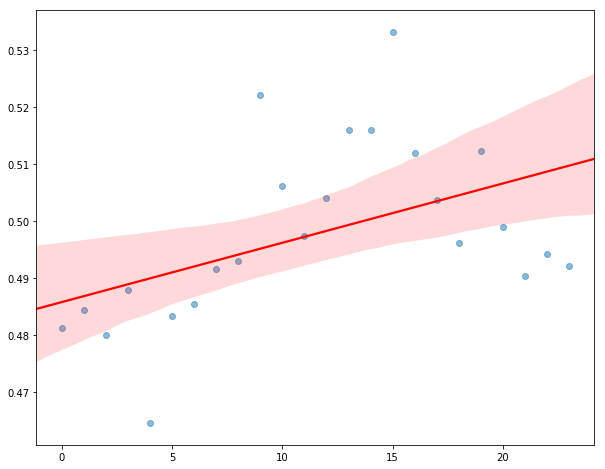

In [29]:
psd(df5, 'dh')

0 10870 11 10870 12 0.46678932842686294
1 10066 10 10066 11 0.48321080866282534
2 9775 9 9775 10 0.48419437340153454
3 9362 7 9362 8 0.5028839991454818
4 9097 8 9097 9 0.501813784764208
5 8887 6 8887 7 0.5065826488128727
6 7841 5 7841 6 0.5012115801555924
7 7599 4 7599 5 0.5149361758126069
8 7126 3 7126 4 0.5011226494527083
9 6882 2 6882 3 0.509880848590526
10 6371 0 6371 1 0.5168733322869251
11 6123 1 6123 2 0.5103707333006696


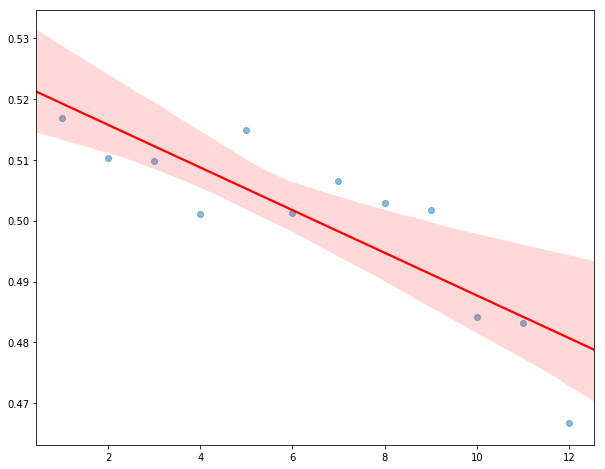

In [27]:
psd(df5, 'dm')

0 15384 3 15384 3 0.5036401456058243
1 15378 2 15378 2 0.5020158668227338
2 15156 1 15156 1 0.5044206914753233
3 14836 4 14836 4 0.4969668374224858
4 14580 0 14580 0 0.4992455418381344
5 12560 6 12560 6 0.49195859872611464
6 12105 5 12105 5 0.48269310202395704


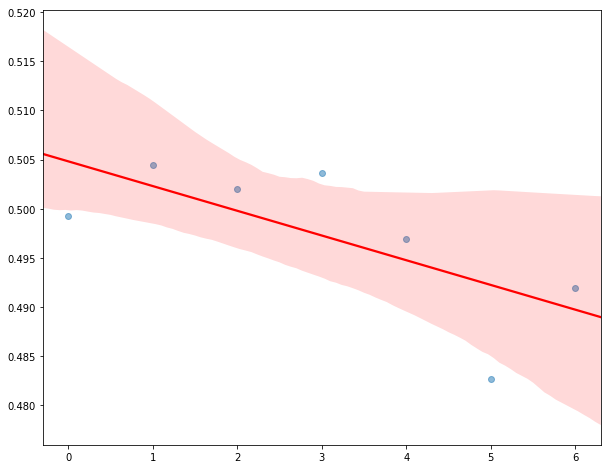

In [28]:
psd(df5, 'dw')

In [13]:
print(df.shape)

(1010826, 10)


In [15]:
df1.index

RangeIndex(start=0, stop=999, step=1)

In [24]:
df1 = shuffle(df1)
df = shuffle(df)

In [19]:
df1.groupby('label')['label'].count()

label
0    939
1     60
Name: label, dtype: int64

In [20]:
df.groupby('label')['label'].count()

label
0    505413
1    505413
Name: label, dtype: int64

In [176]:
r6 = df.groupby('score')['score'].count()
print(r6.shape)
#print(r6[:100])
r61 = np.sort(r6.values)[::-1]
r61[:100]


(1291,)


array([340017, 162678,  90290,  58145,  41979,  38802,  29600,  22810,
        22769,  18064,  14521,  11925,  11815,   9998,   8397,   7277,
         6738,   6391,   5461,   5436,   5037,   4404,   4134,   3951,
         3505,   3096,   3089,   2861,   2600,   2425,   2384,   2146,
         2065,   1874,   1852,   1753,   1644,   1513,   1503,   1450,
         1331,   1183,   1135,   1093,   1071,   1033,    996,    926,
          910,    847,    818,    776,    733,    722,    717,    693,
          681,    621,    587,    570,    546,    537,    537,    511,
          505,    489,    486,    439,    409,    400,    396,    394,
          379,    377,    367,    362,    315,    314,    308,    308,
          299,    295,    292,    291,    276,    268,    259,    252,
          251,    233,    230,    228,    222,    210,    209,    206,
          197,    193,    191,    187], dtype=int64)

In [179]:
u6 = df.groupby('ups')['ups'].count()
print(u6.shape)
#print(u6[:100])
u61 = np.sort(u6.values)[::-1]
u61[:100]

(1171,)


array([289595, 168045, 138993,  76596,  51852,  35704,  32877,  25124,
        19211,  15231,  12310,  10757,   9896,   8391,   7019,   6064,
         6044,   5341,   4874,   4536,   4239,   3726,   3648,   3289,
         2904,   2802,   2597,   2370,   2192,   2159,   1992,   1799,
         1693,   1685,   1561,   1464,   1376,   1368,   1252,   1181,
         1098,   1043,    928,    901,    895,    891,    836,    772,
          746,    689,    683,    674,    644,    590,    586,    580,
          567,    507,    488,    472,    467,    437,    436,    434,
          431,    430,    402,    376,    356,    341,    334,    329,
          321,    319,    312,    300,    274,    262,    259,    255,
          253,    252,    252,    247,    246,    218,    215,    213,
          207,    207,    187,    186,    184,    180,    177,    177,
          167,    153,    153,    152], dtype=int64)

In [184]:
u6[200:400]

ups
76     149
77     149
78     152
79     177
80     141
81     130
82     143
83     122
84     119
85     127
86     138
87     124
88     126
89     116
90     117
91     111
92     120
93      95
94      94
95     103
96      96
97     103
98      86
99     100
100    104
101     89
102     79
103     88
104     66
105     88
      ... 
246     10
247      5
248      9
249     15
250     15
251     17
252      6
253      7
254     10
255      9
256     11
257     16
258     15
259     10
260      9
261      8
262      8
263     11
264      7
265     17
266      8
267      6
268     15
269     14
270      7
271      4
272     11
273     15
274     13
275      8
Name: ups, Length: 200, dtype: int64

In [349]:
df5.head()
dfx = df5.copy()
dfx['sub'] = df5['subreddit']

In [350]:
dfx.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,month,year,t1,dw,dh,dy,dm,dt,sub
0,0,Lol,dayman-mokaffe,nyjets,5,-1,-1,2016-11,2016-11-06 20:56:18,I'll be shocked if he doesnt throw a pick,11,2016,2016-11-06 20:56:18,6,20,2016,11,2016-11-06 20:56:18,nyjets
1,1,Because Blizzard is a charity organization ded...,thatrotteneggsmell,hearthstone,8,8,0,2015-08,2015-08-22 12:32:08,Can anyone explain to me why Blizzard has to g...,08,2015,2015-08-22 12:32:08,5,12,2015,8,2015-08-22 12:32:08,hearthstone
2,0,If you can have no influence in the EU how wil...,lebron181,ukpolitics,3,3,0,2016-06,2016-06-22 19:33:50,"And look at the difference it made, all that h...",06,2016,2016-06-22 19:33:50,2,19,2016,6,2016-06-22 19:33:50,ukpolitics
3,1,Obviously that means she's a casual,Lolola2,survivor,12,12,0,2016-05,2016-05-06 10:45:36,Didn't even cross her mind about Michele winning.,05,2016,2016-05-06 10:45:36,4,10,2016,5,2016-05-06 10:45:36,survivor
4,1,Spoiler alert.,V2Blast,anime,1,1,0,2013-09,2013-09-09 08:27:19,"Well, considering that I don't see Eren and Mi...",09,2013,2013-09-09 08:27:19,0,8,2013,9,2013-09-09 08:27:19,anime


In [ ]:
# Заполнение df по строкам